In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
cls_conf = ffhq256_autoenc_cls()
cls_model = ClsModel(cls_conf)
state = torch.load(f'checkpoints/{cls_conf.name}/last.ckpt',
                    map_location='cpu')
print('latent step:', state['global_step'])
cls_model.load_state_dict(state['state_dict'], strict=False)
cls_model.to(device);

Global seed set to 0


loading pretrain ... 130M
step: 1563562
loading latent stats ...
latent step: 9375


In [5]:
path_src = 'imgs_evaluate/imgs_source'
for i,file in enumerate(os.listdir(path_src)):
    print(i, file)

0 ookawa_default-ookawa_angry2
1 yotaka_default-yotaka_angry2
2 yotaka_default-yotaka_smile


In [6]:
ind_src = 2
ind_parts = [0,1,12,13,6,7,2,5,8,11,3,4,9,10]  # いじらない
path_src_mta = f'{path_src}/{os.listdir(path_src)[ind_src]}'
name_src = os.listdir(path_src)[ind_src]
data_src = ImageDataset(f'{path_src_mta}/parts', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_src = torch.tensor([])
for data in data_src:
    batch_src = torch.cat([batch_src, data['img'][None]])

In [7]:
path_tgt = 'imgs_evaluate/imgs_target'
for i,file in enumerate(os.listdir(f'{path_tgt}/img')):
    print(i, file)

0 glasses.png
1 takebe_default.png
2 test01_03.png
3 test02_02.png
4 woman_default.png


In [8]:
ind_tgt = {2}
data_tgt = ImageDataset(f'{path_tgt}/img', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch_tgt = torch.tensor([])
name_tgt = []
for i,data in enumerate(data_tgt):
    if i in ind_tgt:
        batch_tgt = torch.cat([batch_tgt, data['img'][None]])
        name_tgt.append(os.path.splitext(str(data_tgt.paths[i]))[0])

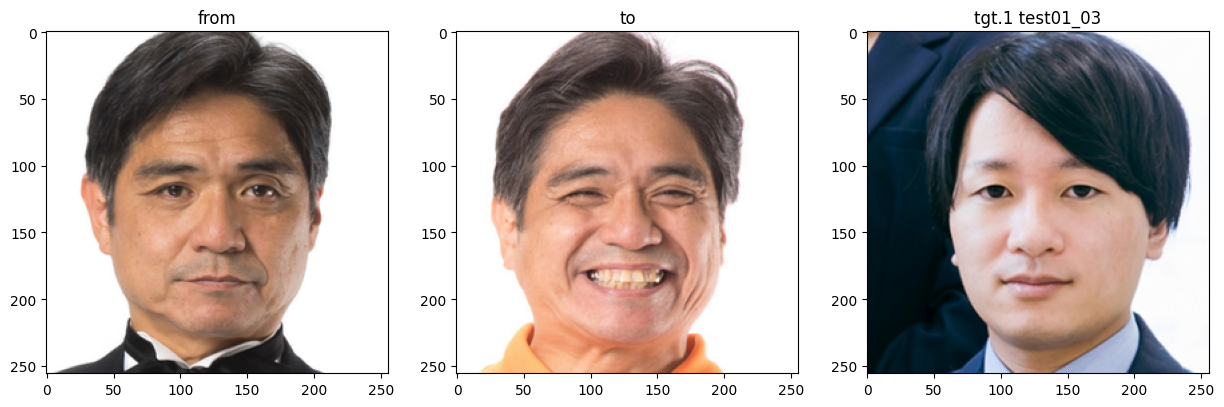

In [222]:
import matplotlib.pyplot as plt

num_tgt = len(batch_tgt)
fig, ax = plt.subplots(1, 2+num_tgt, figsize=(5*(2+num_tgt), 5))
ax[0].imshow(batch_src[0].permute([1, 2, 0]) / 2 + 0.5)
ax[0].set_title(f"from")
ax[1].imshow(batch_src[1].permute([1, 2, 0]) / 2 + 0.5)
ax[1].set_title(f"to")

for i in range(num_tgt):
    ax[i+2].imshow(batch_tgt[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+2].set_title(f"tgt.{i+1} {name_tgt[i]}")

plt.show()

In [10]:
cond_tgt = torch.tensor([], device=device)
xT = torch.tensor([], device=device)
for i in range(num_tgt):
    cond_tgt = torch.cat([cond_tgt, model.encode(batch_tgt[i][None].to(device))], dim=0)
    xT = torch.cat([xT, model.encode_stochastic(batch_tgt[i][None].to(device), cond_tgt[i][None], T=250)], dim=0)

In [175]:
alpha = torch.tensor(np.linspace(0, 1.5, 6, dtype=np.float32)).to(device)

## パーツ選択

In [137]:
dict_parts = {'all':[ind_parts[0],ind_parts[1]],
              'pose':[ind_parts[2],ind_parts[3]],
              'face':[ind_parts[4],ind_parts[5]],
              'eye':[ind_parts[6],ind_parts[7]],
              'mouth':[ind_parts[8],ind_parts[9]],
              'eye_mouth':[ind_parts[10],ind_parts[11]],
              'mouth_nose':[ind_parts[12],ind_parts[13]]}

In [139]:
select = 'mouth_nose'
ind_select = dict_parts[select]

In [140]:
batch_src_parts = torch.stack([batch_src[ind_select[0]], batch_src[ind_select[1]]]).to(device)
cond_src_parts = model.encode(batch_src_parts)
cond_change_parts = cond_src_parts[1] - cond_src_parts[0]

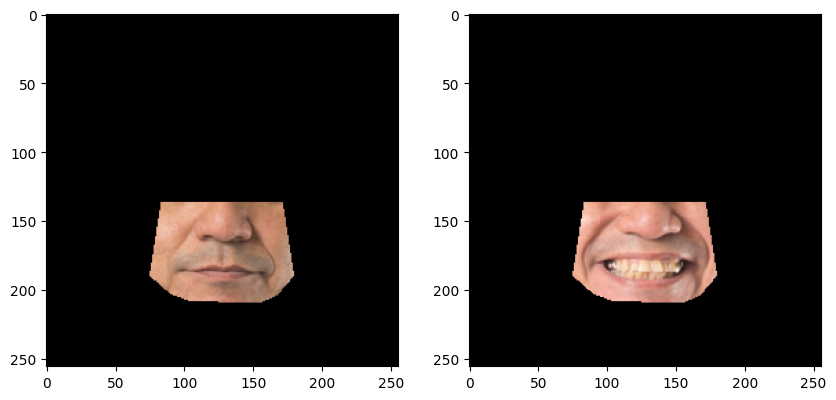

In [141]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))
ax[0].imshow(batch_src[ind_select[0]].permute([1, 2, 0]) / 2 + 0.5)
ax[1].imshow(batch_src[ind_select[1]].permute([1, 2, 0]) / 2 + 0.5)
plt.show()

In [142]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [230]:
import cv2

img_from = cv2.imread(f'{path_src_mta}/parts/{select}_from.png')
img_to = cv2.imread(f'{path_src_mta}/parts/{select}_to.png')
img_from_rgb = cv2.cvtColor(img_from, cv2.COLOR_BGR2RGB)
img_to_rgb = cv2.cvtColor(img_to, cv2.COLOR_BGR2RGB)
img_from_gray = cv2.cvtColor(img_from, cv2.COLOR_BGR2GRAY)
img_to_gray = cv2.cvtColor(img_to, cv2.COLOR_BGR2GRAY)
img_pil_from = Image.open(f'{path_src_mta}/parts/{select}_from.png')
img_pil_to = Image.open(f'{path_src_mta}/parts/{select}_to.png')

imgs_add_from = []
imgs_add_to = []


img_canny_from = cv2.Canny(img_from_gray, 100,200)
img_canny_to = cv2.Canny(img_to_gray, 100,200)
img_canny_from = cv2.cvtColor(img_canny_from, cv2.COLOR_GRAY2BGR)
img_canny_to = cv2.cvtColor(img_canny_to, cv2.COLOR_GRAY2BGR)
imgs_add_from.append(img_canny_from)
imgs_add_to.append(img_canny_to)

# img_sobel_from = cv2.Sobel(img_from_gray, -1, 1, 0, ksize=3)
# img_sobel_to = cv2.Sobel(img_to_gray, -1, 1, 0, ksize=3)
# img_sobel_from = cv2.cvtColor(img_sobel_from, cv2.COLOR_GRAY2BGR)
# img_sobel_to = cv2.cvtColor(img_sobel_to, cv2.COLOR_GRAY2BGR)
# imgs_add_from.append(img_sobel_from)
# imgs_add_to.append(img_sobel_to)

# img_lap_from = cv2.Laplacian(img_from_gray, -1)
# img_lap_to = cv2.Laplacian(img_to_gray, -1)
# img_lap_from = cv2.cvtColor(img_lap_from, cv2.COLOR_GRAY2BGR)
# img_lap_to = cv2.cvtColor(img_lap_to, cv2.COLOR_GRAY2BGR)
# imgs_add_from.append(img_lap_from)
# imgs_add_to.append(img_lap_to)

# img_bi_from = cv2.bilateralFilter(img_from_rgb, 15, 20, 20)
# img_bi_to = cv2.bilateralFilter(img_to_rgb, 15, 20, 20)
# imgs_add_from.append(img_bi_from)
# imgs_add_to.append(img_bi_to)

# for i in range(1, 10):
#     img_blur_from = cv2.blur(img_from_rgb, (i,i))
#     img_blur_to = cv2.blur(img_to_rgb, (i,i))
#     imgs_add_from.append(img_blur_from)
#     imgs_add_to.append(img_blur_to)


def make_sharp_kernel(k: int):
  return np.array([
    [-k / 9, -k / 9, -k / 9],
    [-k / 9, 1 + 8 * k / 9, k / 9],
    [-k / 9, -k / 9, -k / 9]
  ], np.float32)

# for i in range(1,10):
#     kernel = make_sharp_kernel(i)
#     img_unsharp_from = cv2.filter2D(img_from_rgb, -1, kernel).astype("uint8")
#     img_unsharp_to = cv2.filter2D(img_to_rgb, -1, kernel).astype("uint8")
#     imgs_add_from.append(img_unsharp_from)
#     imgs_add_to.append(img_unsharp_to)

# img_unsharp2_from = cv2.GaussianBlur(img_from_rgb, (9,9), 10.0)
# img_unsharp2_to = cv2.GaussianBlur(img_to_rgb, (9,9), 10.0)
# img_unsharp2_from = cv2.addWeighted(img_from_rgb, 2.0, img_unsharp2_from, -1.0, 0, img_from_rgb)
# img_unsharp2_to = cv2.addWeighted(img_to_rgb, 2.0, img_unsharp2_to, -1.0, 0, img_to_rgb)
# imgs_add_from.append(img_unsharp2_from)
# imgs_add_to.append(img_unsharp2_to)

# std_from = np.std(img_from_gray.flatten()[img_from_gray.flatten() > 1])
# std_to = np.std(img_to_gray.flatten()[img_to_gray.flatten() > 1])
# mean_from = np.mean(img_from_gray.flatten()[img_from_gray.flatten() > 1])
# mean_to = np.mean(img_to_gray.flatten()[img_to_gray.flatten() > 1])
# std = std_from / std_to
# mean = mean_from - mean_to

# img_contrast_from = cv2.convertScaleAbs(img_from_rgb, alpha=1, beta=0)
# img_contrast_to = np.where(img_to_rgb > 1, np.uint8(img_to_rgb*std), img_to_rgb)
# img_contrast_to = np.where(img_contrast_to > 255, 255, img_contrast_to)
# imgs_add_from.append(img_contrast_from)
# imgs_add_to.append(img_contrast_to)

# imgs_add_from.append(cv2.cvtColor(img_from_gray, cv2.COLOR_GRAY2RGB))
# imgs_add_to.append(cv2.cvtColor(img_to_gray, cv2.COLOR_GRAY2RGB))

num_test = len(imgs_add_from)

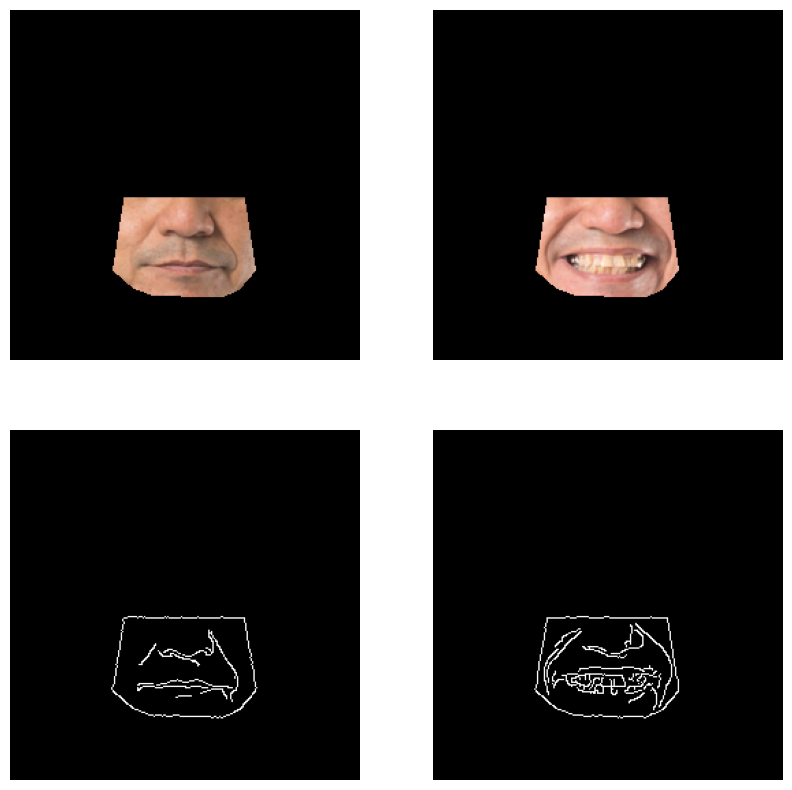

In [231]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(num_test+1, 2, figsize=(5*2, 5*(num_test+1)))
ax[0,0].imshow(batch_src[ind_select[0]].permute([1, 2, 0]) / 2 + 0.5)
ax[0,1].imshow(batch_src[ind_select[1]].permute([1, 2, 0]) / 2 + 0.5)
ax[0,0].axis('off')
ax[0,1].axis('off')
for i,(f,t) in enumerate(zip(imgs_add_from, imgs_add_to)):
    ax[i+1,0].imshow(f)
    ax[i+1,1].imshow(t)
    ax[i+1,0].axis('off')
    ax[i+1,1].axis('off')

# plt.savefig('imgs_add_test/canny_mouth.png')
plt.show()

In [232]:
cond_add = []

for f,t in zip(imgs_add_from, imgs_add_to):
    cond_from = model.encode(transform(f)[None].to(device))
    cond_to = model.encode(transform(t)[None].to(device))
    cond_add.append((cond_to - cond_from)[0])

In [235]:
preds_parts = torch.tensor([], device=device)
for test in range(num_test+1):
    preds_tmp = torch.tensor([], device=device)
    for i in range(num_tgt):
        preds_tmp2 = torch.tensor([], device=device)
        for j,alp in enumerate(alpha):
            cond = cond_tgt[i] + alp * cond_change_parts
            if test != 0:
                cond = cond_tgt[i] + alp * cond_add[test-1]
                # cond = cond + alp * cond_add[test-1] 
            pred = model.render(xT[i][None], cond[None], T=20)
            preds_tmp2 = torch.cat([preds_tmp2, pred], dim=0)
        preds_tmp = torch.cat([preds_tmp, preds_tmp2[None]], dim=0)
    preds_parts = torch.cat([preds_parts, preds_tmp[None]], dim=0)

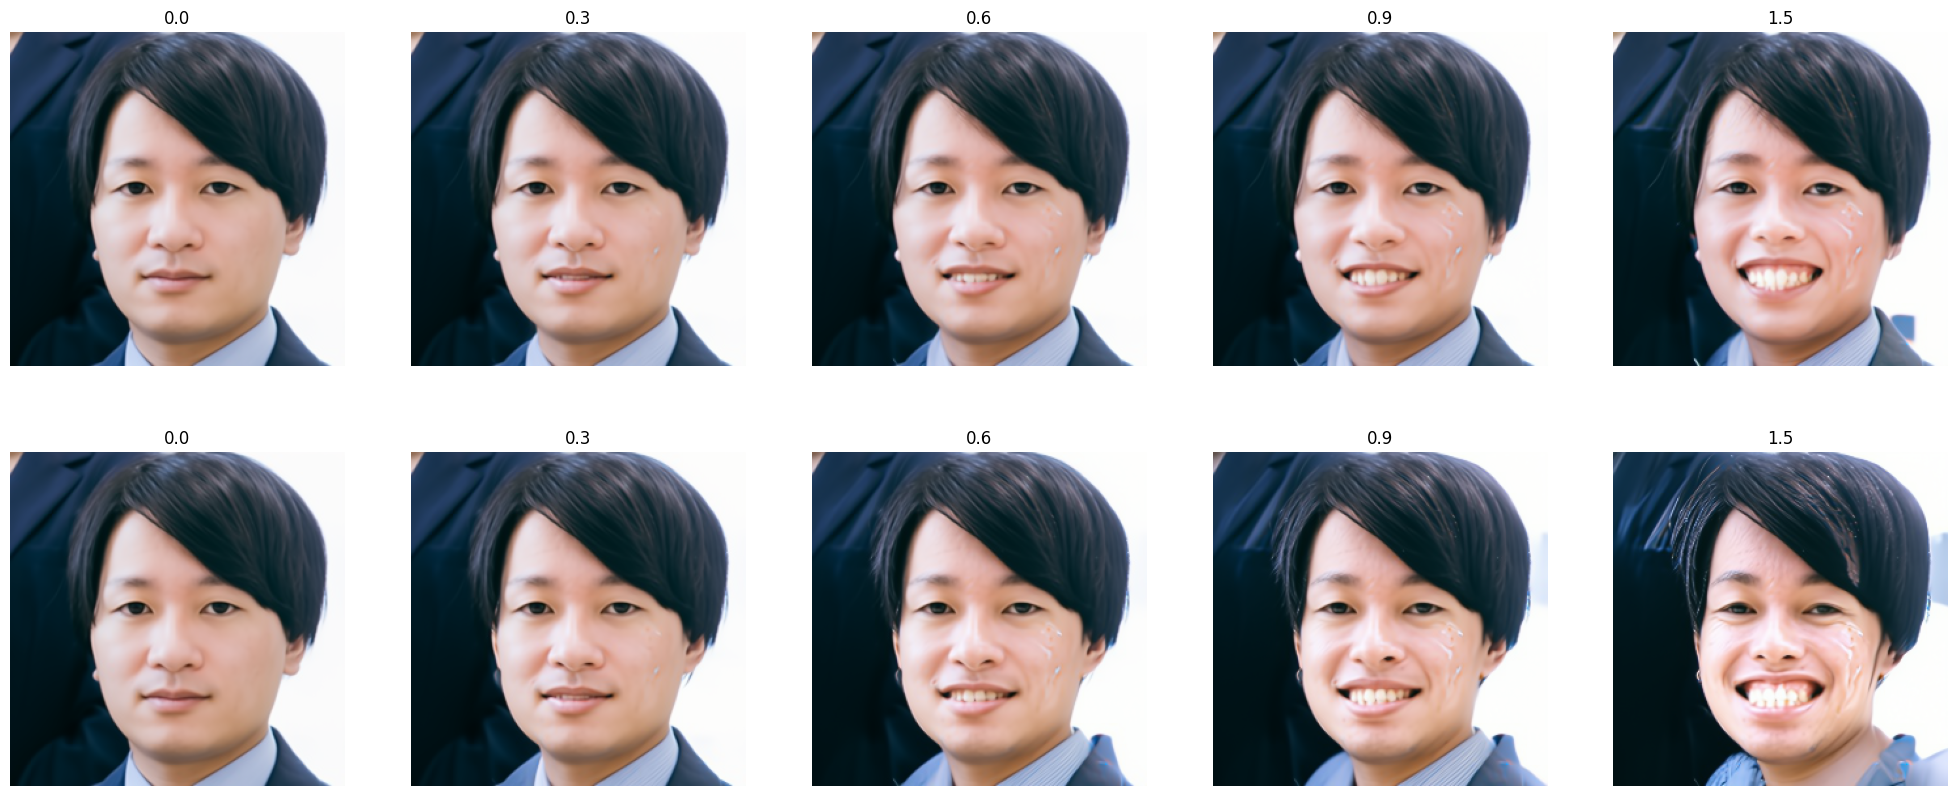

In [236]:
import matplotlib.pyplot as plt

num_col = 5
fig,ax = plt.subplots(num_tgt*(num_test+1), num_col, figsize=(5*num_col, 5*num_tgt*(num_test+1)))
for i in range(num_tgt):
    for t in range((num_test+1)):
        for j,k in enumerate(np.linspace(0,len(preds_parts[t,i])-1,num_col,dtype=np.uint8)):
            if (num_test+1)*num_tgt < 2:
                ax[j].imshow(preds_parts[t,i,k].permute(1,2,0).cpu())
                ax[j].set_title(np.array(alpha[k].cpu()))
                ax[j].axis('off')
            else:
                ax[i*(num_test+1)+t,j].imshow(preds_parts[t,i,k].permute(1,2,0).cpu())
                if i == 0:
                    ax[i*(num_test+1)+t,j].set_title(np.array(alpha[k].cpu()))
                ax[i*(num_test+1)+t,j].axis('off')

# plt.savefig("imgs_add_test/canny_plus_mouth_transfer")

In [437]:
from PIL import Image

preds_pil = []
for pred in preds_parts:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pil.append(pred_pil)

In [438]:
dst_dir = f"imgs_evaluate/results/additional/{name_src}"

In [439]:
for i,pred_pil in enumerate(preds_all_pil):
    dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/all/"
    if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = dst_dir_parts + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=4000//(len(alpha)),
        loop=0,
    )

In [ ]:
select_frame = {0,2,4,6,8,10,12,14,15}

In [295]:
from torchvision.utils import save_image

if flag_change:
    for i,pred in enumerate(preds_all):
        dst_dir_parts = f"{dst_dir}/{name_tgt[i]}/all/"
        if not os.path.exists(dst_dir_parts): os.makedirs(dst_dir_parts)
        for j,p in enumerate(pred):
            if j in select_frame:
                file_name = f"{dst_dir_parts}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
                save_image(p, file_name, format='PNG')